In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import calendar

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///resources/hawaii.sqlite")
inspect(engine).get_table_names()

['measurement', 'station']

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [7]:
# List Columns in the Measurement table
columns = inspect(engine).get_columns("measurement")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# List Columns in the Station table
columns = inspect(engine).get_columns("station")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
connection = engine.connect()
latest_date = (session
               .query(func.max(Measurement.date))
               .scalar()
)
latest_date

'2017-08-23'

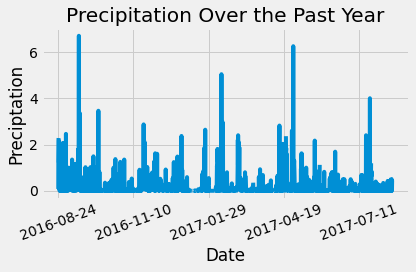

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date

# Calculate the date one year from the last date in data set.
date_last_year = dt.datetime.strptime(latest_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_year = (session
             .query(Measurement.date, Measurement.prcp)
             .order_by(Measurement.date)
             .filter(Measurement.date >= date_last_year).all()
)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(last_year, columns=["Date","Precipitation"])
prcp_df.set_index("Date", inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(title="Precipitation by Date")
plt.xlabel("Date")
plt.ylabel("Preciptation")
plt.title("Precipitation Over the Past Year")
plt.xticks(rotation = 20)
plt.tight_layout()
ax.get_legend().remove()
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
station_count = (session
                 .query(Station.id)
                 .group_by(Station.id).count()
)
station_count

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_actives_list = (session
    .query(Measurement.station,func.count(Measurement.station))
    .filter(Station.station == Measurement.station)
    .group_by(Measurement.station)
    .order_by(func.count(Station.station).desc())
    .all()
)

most_active = (session
    .query(Measurement.station,func.count(Measurement.station))
    .filter(Station.station == Measurement.station)
    .group_by(Measurement.station)
    .order_by(func.count(Station.station).desc())
    .first()
)




print("Most Active Stations")
most_actives_list

Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.mos
most_active_stats = (session
              .query(func.min(Measurement.tobs),
                     func.max(Measurement.tobs),
                     func.avg(Measurement.tobs))
              .filter(Measurement.station == most_actives_list[0][0])
              .first()
)

f"Low: {most_active_stats[0]}, high: {most_active_stats[1]}, average: {most_active_stats[2]}"

'Low: 54.0, high: 85.0, average: 71.66378066378067'

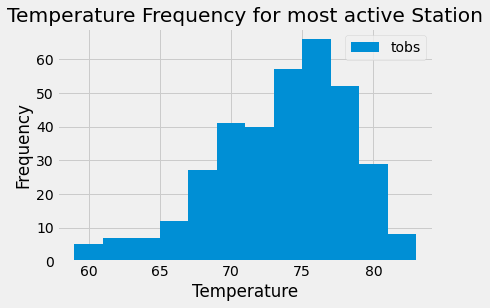

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_data = (session
    .query(Measurement.tobs)
    .filter(Station.station == Measurement.station)
    .filter(Measurement.station == most_actives_list[0][0])
    .filter(Measurement.date >= date_last_year)
    .all()
)

fig, ax = plt.subplots()

ax.hist(pd.DataFrame(most_active_data), 12)

ax.set_xlabel("Temperature")
ax.set_ylabel("Frequency")
ax.legend(["tobs"],loc="best")
ax.set_title("Temperature Frequency for most active Station")

plt.show()

# Close session

In [19]:
# Close Session
session.close()